This example swaps the OLS component for a small feed‑forward NN to test whether a non‑linear regression models can improve tail‑threshold trading performance. We hold all data, features, walk‑forward parameters, and cost assumptions constant to isolate model effect.

In [17]:

from wft import  fetch_yf_data, WalkForward, assess_performance
from wft.plot_variables import  Visualization as vis 
from wft.models import NeuralNetwork as nn
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

def compute_atr(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
    # Calculate the True Range (TR)
    high_low = high - low
    high_close_prev = (high - close.shift()).abs()
    low_close_prev = (low - close.shift()).abs()

    tr = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)

    # Calculate the ATR
    atr = tr.ewm(span=period, min_periods=1, adjust=False).mean() 
    return atr

def compute_variables(ohlc: pd.DataFrame, lookahead:int = 1) -> pd.DataFrame:
    # data is already in log form
    open   = ohlc['Open']
    close  = ohlc['Close']
    low    = ohlc['Low']
    high   = ohlc['High']
    volume = ohlc['Volume']

    weekly_atr = compute_atr(high , low , close , 5)
    monthly_atr = compute_atr(high , low , close , 21)

    upper  = high - np.maximum(close , open)
    lower   = np.minimum(close , open)  - low
    assymmetry = upper - lower
    Intraday_assymmetry_standardized = assymmetry/ ( assymmetry.ewm(span = 20, adjust= False).std())

    vol_mean20 = volume.ewm(span = 20, adjust= False).mean()
    vol_surprise = volume  / vol_mean20 -1
    vol_surprise/=vol_surprise.ewm(span = 20, adjust= False).std()

    return5_over_atr = close.diff(5)/monthly_atr 

    df = pd.DataFrame(index = ohlc.index)

    df['return5_over_atr'] = return5_over_atr
    df['Intraday_assymmetry']   = Intraday_assymmetry_standardized
    df['vol_surprise']   = vol_surprise

    target =  close.diff(lookahead).shift(-lookahead)/weekly_atr 
    df.iloc[:20] = np.nan
    target.iloc[:20] = np.nan
    return df, target

We start with sample spanning from 1995 to 2000 for finding "Optimal" learning rates and number of epoches,
The neural network is trained using Gradient Descent and the AdaGrad optimizer

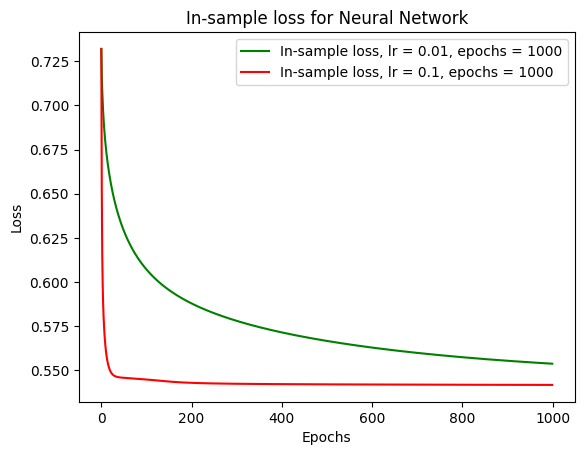

In [8]:
data = fetch_yf_data('SPY', start_date='1995-01-01', end_date='2000-01-01', auto_adjust=False)  ## Download data, built in function, see file Data.py
df,target = compute_variables(data)  # Function defined above
np.random.seed(1)

activcation_function = 'relu'
lr = 0.01
epochs = 1000

model = nn( activation_f=activcation_function, n_hidden=3, lr= 0.01, n_iter=1000, bias =True)
model2 = nn( activation_f=activcation_function, n_hidden=3, lr=0.1, n_iter=1000, bias =True)
model.fit(df.iloc[22:-1], target.iloc[22:-1])
model2.fit(df.iloc[22:-1], target.iloc[22:-1])

in_sample_loss_model1 = np.array(model.current_loss)
in_sample_loss_model2 = np.array(model2.current_loss)

plt.plot(in_sample_loss_model1, label='In-sample loss, lr = 0.01, epochs = 1000', color= 'green')
plt.plot(in_sample_loss_model2, label='In-sample loss, lr = 0.1, epochs = 1000', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')  
plt.title('In-sample loss for Neural Network')
plt.legend()
plt.show()




From the plot above we can see that a learning rate of 0.1 (red) converges faseter than a learning rate of 0.01(green)  
when using a small NN with 3 hidden neurons.

Thus for the walkforward tail regression, where a small feed forward neural network is deployed,     
the learning rate will be sat at 0.1 and the number of epochs to 200,
as the curve of the loss seem to plateau afterwards

Selection of the hidden layer size and activation function is performed via k-fold cross‑validation within each walk‑forward training window.   
For each activation function (sigmoid, relu) we test hidden unit counts h ∈ {3,4,5,6,7,8}.  
The combination yielding the lowest cross‑validated Mean Absolute Error is chosen for the out of sample fold.

The dipendent and indipendent variables are standardized (mean =0, variance = 1) at each training step,     
with the transformation fitted on the training data and then applied at each case of the test set.

Note that to class implement in this code does not make use CUDA infrastructure, so the training process will be fairly slow.

Expected Runtime < 3 mins

p-value under H0: mean_return <=0 = 1.16 %
Mean Return: 0.082 %
Lower Confidence Interval: 0.02%
Upper Confidence Interval: 0.14%


c:\Users\andre\Desktop\VS-code_projects\Project\wft\plot_variables.py:259: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method = "ffill", inplace =True)


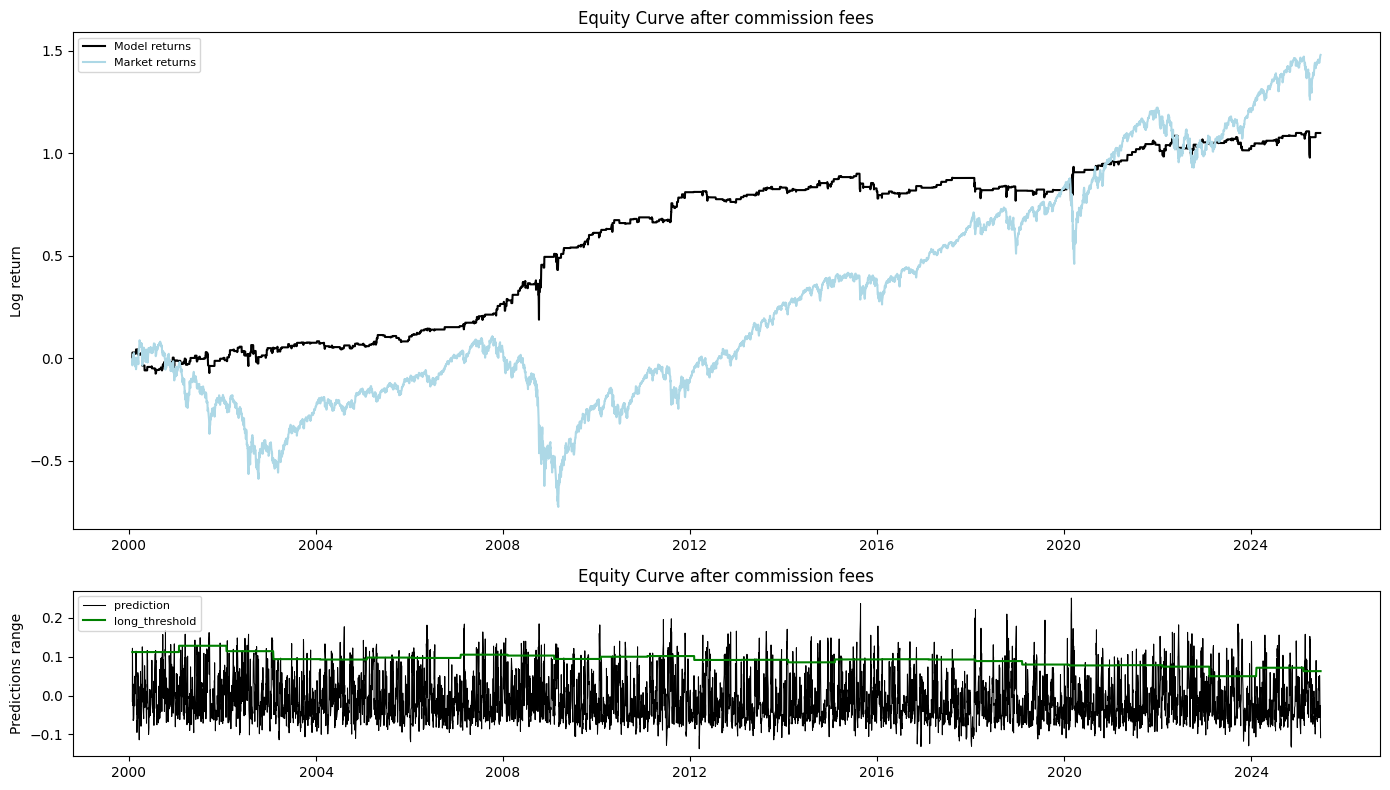

Model Decision Extrapolation:
                     mu_long_over_t  std_long  mu_long/std_long
return5_over_atr          -1.811595  1.180513         -1.534583
Intraday_assymmetry        0.971520  0.783816          1.239474
vol_surprise               0.773008  0.873434          0.885022
                          Model
Annual Return %            3.87
Sharpe Ratio Annualized    0.98
Mean Return %              0.08
Total Return %           109.80
Max Drawdown %            19.19
Profit Factor              1.28
Sharpe Ratio benchmarck    0.44
Time in the market %      21.02


In [16]:
if __name__ == '__main__':
    np.random.seed(42)
    data = fetch_yf_data('SPY', start_date='1995-01-01', end_date='2025-07-01', auto_adjust=False)  # Download data, built in function, see file Data.py
    inputs,target = compute_variables(data, lookahead=1)
    # IMPORTANT THE PROGRAM EXCPECT THE CLOSE TO BE IN LOGARITHMIC SCALE OTHERWISE RETURNS WILL BE OFF ##

    # Walk-forward configurations
    start_train = 252*5      # First training window start Index
    train_size =   0         # All past data
    step_size = 21*12          # Retrain every 12  months because is slow 
    lookahead  = 1
    commision  = 0.0001        # 0.1 bp per change in position
    criterion = 'sharpe_ratio' # Criterion to maximize
    min_trades = .1  # Minimum number of trades to consider the model valid
    ohlc =data[['Open', 'High', 'Low', 'Close']].copy()  ## Ohlc data, used for computing returns 


    model_components = ['nn']            # Neural Network Model
    preprocess_variables =  [ 'X','y']   # Preprocess these variables 
    preprocess_type = ['standardize']    # Standardize the inputs and target variables
    model_kwargs ={'nn': {'n_hidden':5, 'activation_f':'relu','bias':True,'lr':0.1, 'n_iter':200 }} # Starting hyperparameters for the model  
    grid_hyperparams = []  # here we store crossvalidation hyperparameters to be tested
    # Test different number of hidden neurons and activation functions
    for i in range(3,8+1):   # Max 8 neurons in hidden layer, small models are always better
            grid_hyperparams.append({'nn':{'n_hidden':i, 'activation_f':'relu' }})
            grid_hyperparams.append({'nn':{'n_hidden':i, 'activation_f':'sigmoid'}})
    # Cross Validation Parameters
    # Here we use a 3-fold cross validation, with the evaluation metric being the mean absolute error
    # This means that during each training window, the model will be trained on 3 folds of the data, and the mean absolute error will be used to select the best features.
    kwargs_cv = {'cv_folds': 3, 'eval_metric':'mae'}

    WF = WalkForward(
                    inputs = inputs,
                    targets = target,
                    ohlc = ohlc,
                    max_lookahead = lookahead,
                    model_components = model_components,
                    criterion = criterion,
                    min_trades = min_trades,
                    model_kwargs = model_kwargs,
                    grid_hyperparams=grid_hyperparams,
                    kwargs_cv=kwargs_cv,
                    preprocess_variables = preprocess_variables,
                    preprocess_type = preprocess_type,
                    side = 'long',
                        )


    net_log_ret, long_stats, short_stats = WF.run(start_train= start_train,
                                           train_size = train_size,
                                           step_size=step_size, commision=0.0001)
    
    mean_ret = np.round(100*net_log_ret[net_log_ret!=0].mean(),3)
    p_value, ci = assess_performance.p_value_returns(net_log_ret.values)
    print(f'p-value under H0: mean_return <=0 = {(100*p_value):.2f} %')
    print(f'Mean Return: {mean_ret} %')
    print(f'Lower Confidence Interval: {(ci[0]):.2f}%')
    print(f'Upper Confidence Interval: {(ci[1]):.2f}%')  
    
    vis.plot_single_equity_curve(net_log_ret,WF.model, WF.inputs ,long_stats,short_stats, bench_mark_returns=data['Close'].diff().fillna(0)) 
    threshold_dict = {'long': long_stats, 'short': short_stats}
    print("Model Decision Extrapolation:")
    print(assess_performance.extrapolate_decision_model(WF.inputs, WF.model, threshold_dict, transform='standardize').to_string())
    df_performance = assess_performance.performance_table(net_log_ret, 'Model', data['Close'].diff().fillna(0), start=start_train).T 
    print(df_performance.to_string())



# %%


The neural network based model proposed, shows no sign of improvements, compared to the first linear model.
Som influencing factor that could have inder neural network performance:     
- The higher step size may deflate the performance 
- too few folds on the cross validation

below a comparative performance table of the two model proposed

| Metric                   | OLS    | Neural Network|
|--------------------------|--------|---------------|
| Annual Return %          | 4.58   |     3.87      |
| Sharpe Ratio Annualized  | 1.15   |     0.98      |
| Mean Return %            | 0.09   |     0.08      |
| Total Return %           | 129.84 |   109.80      |
| Max Drawdown %           | 17.51  |    19.19      |
| Profit Factor            | 1.33   |     1.28      |
| Time in the market %     | 21.46  |    21.02      |

The NN’s net Sharpe (0.98) modestly underperform OLS (1.15);    
This indicates the non‑linearity did not translate into better tail discrimination under this feature set,  
illustrating that added complexity does not automatically yield higher out‑of‑sample Sharpe.    

OLS remains the preferred baseline. 

In [15]:
median_n_hidden = np.median([name['nn']['n_hidden'] for name in long_stats['best_params_cv']])
functions_choices =  [name['nn']['activation_f'] for name in long_stats['best_params_cv']]
print(f'median number of hidden neurons chosen by CV: {median_n_hidden}')
print(f'Most common activation function chosen by CV: {max(functions_choices, key=functions_choices.count)}')

median number of hidden neurons chosen by CV: 3.0
Most common activation function chosen by CV: sigmoid
